In [5]:
repo_directory = '/Users/iaincarmichael/Dropbox/Research/law/law-net/'

data_dir = '/Users/iaincarmichael/Documents/courtlistener/data/'

import numpy as np
import sys
import matplotlib.pyplot as plt


# graph package
import igraph as ig

# our code
sys.path.append(repo_directory + 'code/')
from setup_data_dir import setup_data_dir, make_subnetwork_directory
from pipeline.download_data import download_bulk_resource, download_master_edgelist, download_scdb
from helpful_functions import case_info

sys.path.append(repo_directory + 'vertex_metrics_experiment/code/')
from rankscore_experiment_sort import *
from rankscore_experiment_LR import *
from rankscore_experiment_search import *

from make_tr_edge_df import *


# which network to download data for
network_name = 'scotus' # 'federal', 'ca1', etc


# some sub directories that get used
raw_dir = data_dir + 'raw/'
subnet_dir = data_dir + network_name + '/'
text_dir = subnet_dir + 'textfiles/'


# jupyter notebook settings
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
G = ig.Graph.Read_GraphML(subnet_dir + network_name +'_network.graphml')

## parameters from make snapshots

In [5]:
vertex_metrics = ['indegree', 'outdegree', 'degree',
                  'd_pagerank','u_pagerank',
                  'authorities', 'hubs',
                  'd_eigen', 'u_eigen',
                  'd_betweenness', 'u_betweenness',
                  'd_closeness', 'u_closeness']

# add recent citations
vertex_metrics += ['recentcite_' + str(t) for t in np.arange(1, 10 + 1)]
vertex_metrics += ['recentcite_' + str(t) for t in [15, 20, 25, 30, 35, 40]]

vertex_metrics += ['age']

active_years = range(1900, 2015 + 1)

## test parameters

In [6]:
test_params = {'active_years':  active_years,
               'seed': 4332,
               'num_test_cases': 1000}

# log reg parameters

In [6]:
# how many abset edges to add
num_absent_edges = len(G.es)
seed_edge_df = 32432

# include similarity in logistic regrssion
include_similarity = True

# how to normalize yearly metrics
metric_normalization = 'mean'

# rank by sorting

In [7]:
%time scores_sort = get_rankscores_sort(G, test_params, metrics, subnet_dir)

age
indegree
outdegree
degree
d_pagerank
authorities
hubs
recentcite_5
recentcite_10
recentcite_15
recentcite_20
recentcite_25
recentcite_30
CPU times: user 35min 58s, sys: 41.8 s, total: 36min 39s
Wall time: 36min 38s


In [35]:
sort_mean = scores_sort.mean()
sort_mean.sort_values(ascending=False,inplace=True)
sort_mean

age              0.807917
hubs             0.771656
recentcite_10    0.763933
degree           0.763092
recentcite_15    0.759500
recentcite_5     0.758426
outdegree        0.758392
recentcite_20    0.749317
recentcite_25    0.740306
recentcite_30    0.730266
authorities      0.692209
indegree         0.650751
d_pagerank       0.569745
dtype: float64

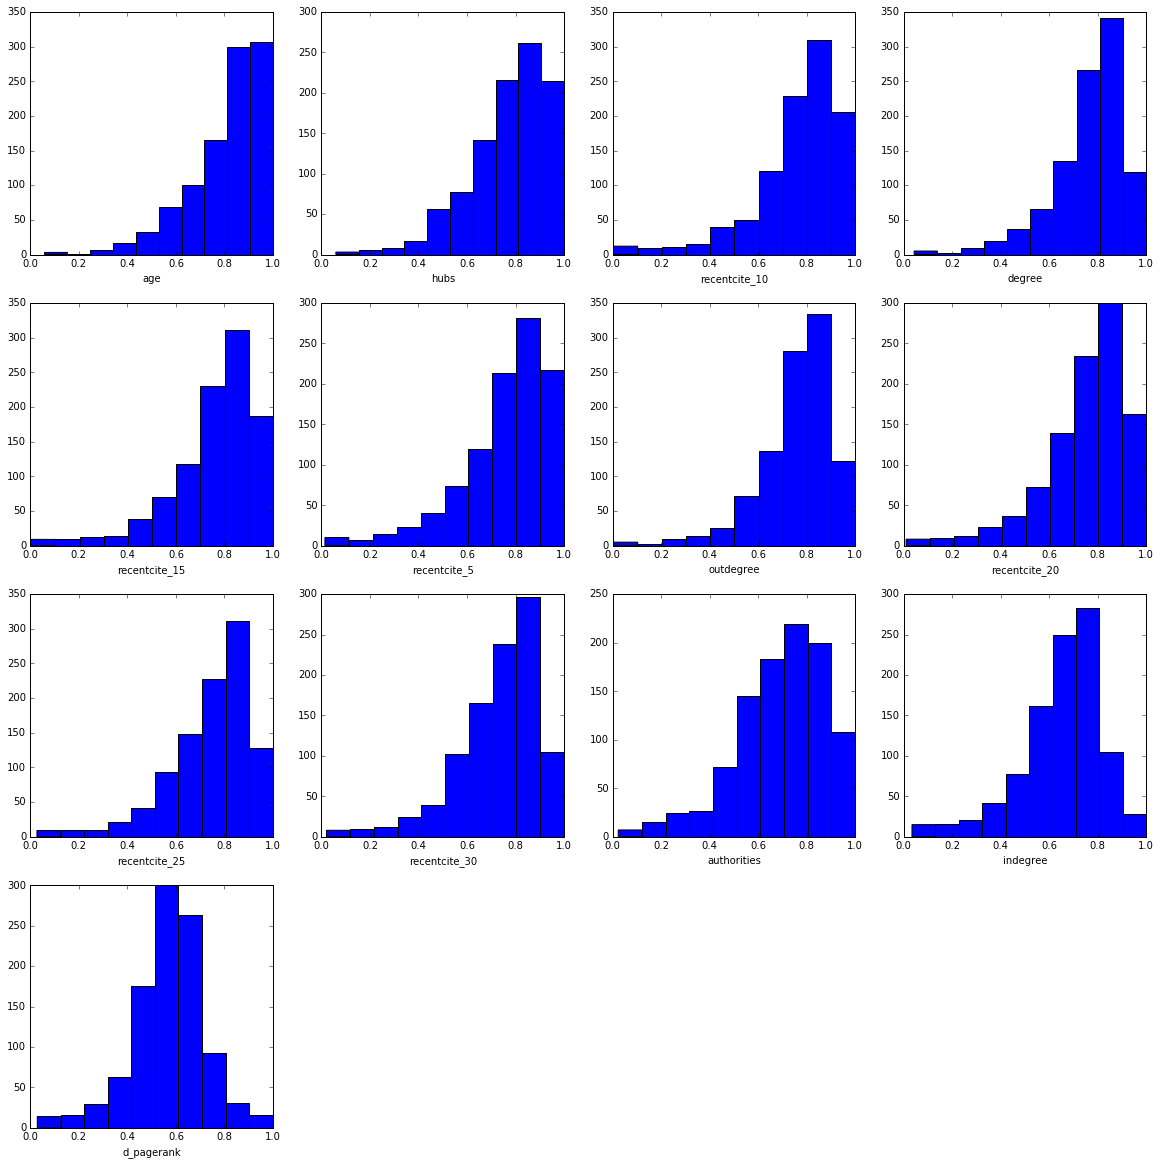

In [38]:
plt.figure(figsize=[20, 20])
k = 1
h = ceil(scores_sort.shape[1] / 4.0)
for c in sort_mean.index:
    plt.subplot(h, 4, k)
    plt.hist(scores_sort[c])
    plt.xlabel(c)
    
    k += 1

# logistic regression

## make training data for logistic regression

In [13]:
num_absent_edges = len(G.es)
metric_normalization = 'mean'

seed_edge_df = 342

In [14]:
%%time 

make_tr_edge_df(G, subnet_dir,
                active_years, num_absent_edges,
                vertex_metrics, metric_normalization,
                seed=seed_edge_df)

CPU times: user 5min 44s, sys: 41.7 s, total: 6min 25s
Wall time: 6min 25s


# rank by logistic regression

In [19]:
vertex_metrics += ['similarity']

include_similarity = True

In [21]:
%%time

scores_LR = get_rankscores_LR(G, test_params, vertex_metrics,
                              include_similarity, subnet_dir,
                              metric_normalization)              

In [37]:
s = scores_LR.mean()

s.sort_values()

recentcite_10    0.233793
degree           0.236823
recentcite_15    0.238209
outdegree        0.240479
recentcite_20    0.248846
recentcite_25    0.260073
recentcite_30    0.269878
indegree         0.349760
d_pagerank       0.570916
authorities      0.688040
recentcite_5     0.761556
hubs             0.766908
age              0.807966
dtype: float64

# search

In [80]:
test_params = {'active_years':  active_years,
               'seed': 4332,
               'num_test_cases': 1000}

num_to_keep = 1000

metrics = ['indegree', 'age', 'outdegree']

In [1]:
%%time
scores_search = get_rankscores_search(G, test_params,
                                      metrics, subnet_dir, num_to_keep)

# surgery

In [6]:
from pipeline.download_data import url_to_dict


In [7]:
op_id = 107423